<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Deploying_TensorFlow_Models_with_TF_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Once we have a beautiful model that makes amazing predictions, what do we do with it? Well, we need to put it in production! This could be as simple as running the model on a batch of data and perhaps writing a script that runs this model every night. However, it is often much more involved. Various parts of our infrastructure may need to use this model on live data, in which case we probably want to wrap our model in a web service: this way, any part of our infrastructure can query our model at any time using a simple REST API (or some other protocol). But as time passes, we need to regularly retrain our model on fresh data and push the updated version to production. We must handle model versioning, gracefully transition from one model to the next, possibly roll back to the previous model in case of problems, and perhaps run multiple different models in parallel to perform A/B experiments. If our product becomes successful, our service may start to get plenty of queries per second (QPS), and it must scale up to support the load. A great solution to scale up our service, as we will see in this notebook, is to use [TF Serving](https://www.tensorflow.org/tfx/guide/serving), either on our own hardware infrastructure or via a cloud service such as Google Cloud AI Platform. It will take care of efficiently serving our model, handle graceful model transitions, and more. If we use the cloud platform, we will also get many extra features, such as powerful monitoring tools.

Moreover, if we have a lot of training data, and compute-intensive models, then training time may be prohibitively long. If our product needs to adapt to changes quickly, then a long training time can be a showstopper (e.g., think of a news recommendation system promoting news from last week). Perhaps even more importantly, a long training time will prevent us from experimenting with new ideas. In Machine Learning (as in many other fields), it is hard to know in advance which ideas will work, so we should try out as many as possible, as fast as possible. One way to speed up training is to use hardware accelerators such as GPUs or TPUs. To go even faster, we can train a model across multiple machines, each equipped with multiple hardware accelerators. TensorFlow’s simple yet powerful Distribution Strategies API makes this easy, as we will see.

In this notebook we will look at how to deploy models to TF Serving, then to Google Cloud AI Platform in the next notebook. We will also take a quick look at deploying models to mobile apps, embedded devices, and web apps in the next notebooks. We will discuss how to speed up computations using GPUs and how to train models across multiple devices and servers using the Distribution Strategies API.

# Serving a TensorFlow Model

Once we have trained a TensorFlow model, we can easily use it in any Python code: if it’s a tf.keras model, we just call its `predict()` method! But as our infrastructure grows, there comes a point where it is preferable to wrap our model in a small service whose sole role is to make predictions and have the rest of the infrastructure query it (e.g., via a REST or gRPC API). This decouples our model from the rest of the infrastructure, making it possible to easily switch model versions or scale the service up as needed (independently from the rest of our infrastructure), perform A/B experiments, and ensure that all our software components rely on the same model versions. It also simplifies testing and development, and more. We could create our own microservice using any technology we want (e.g., using the [Flask library](https://github.com/pallets/flask)), but why reinvent the wheel when we can just use TF Serving?

## Using TensorFlow Serving

TF Serving is a very efficient, battle-tested model server that’s written in C++. It can sustain a high load, serve multiple versions of our models and watch a model repository to automatically deploy the latest versions, and more (see Figure 19-1).

![](https://i.ibb.co/NtKhHr0/TF-serving.png)

### Load the data a train the model 

So let’s train a model in the [MNIST dataset](https://keras.io/api/datasets/mnist/) using tf.keras, and then we will deploy it to TF Serving. 

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
# import the Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# scale the values to 0.0 to 1.0
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.

# reshape for feeding into the model
X_train_full = X_train_full.reshape(X_train_full.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Take 3 examples from the test data to make predictions when model is served
#X_new = X_test[:3]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# simple CNN
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

# train and evaluate our model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3884 - accuracy: 0.8915 - val_loss: 0.2506 - val_accuracy: 0.9294
Epoch 2/2
313/313 [==============================] - 1s 2ms/step - loss: 0.2014 - accuracy: 0.9442

Test accuracy: 0.9441999793052673


The first thing we have to do for deploying the model to TF Serving is export this model to TensorFlow’s *SavedModel format*.

### Exporting SavedModels

TensorFlow provides a simple `tf.saved_model.save()` function to export models to the SavedModel format. All we need to do is give it the model, specifying its name and version number, and the function will save the model’s computation graph and its weights:

In [ ]:
model_version = "0001"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
print('Path where the model will be stored: {}\n'.format(model_path))
tf.saved_model.save(model, model_path)

Path where the model will be stored: my_mnist_model/0001

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_mnist_model/0001/assets


Alternatively, we can just use the model’s `save()` method (`model.save(model_​path)`): as long as the file’s extension is not `.h5`, the model will be saved using the SavedModel format instead of the HDF5 format.

It’s usually a good idea to include all the preprocessing layers in the final model we export so that it can ingest data in its natural form once it is deployed to production. This avoids having to take care of preprocessing separately within the application that uses the model. Bundling the preprocessing steps within the model also makes it simpler to update them later on and limits the risk of mismatch between a model and the preprocessing steps it requires.

**Note**: Since a SavedModel saves the computation graph, it can only be used with models that are based exclusively on TensorFlow operations, excluding the `tf.py_function()` operation (which wraps arbitrary Python code). It also excludes dynamic tf.keras models, since these models cannot be converted to computation graphs. Dynamic models need to be served using other tools (e.g., Flask).

A SavedModel represents a version of our model. It is stored as a directory containing a `saved_model.pb` file, which defines the computation graph (represented as a serialized protocol buffer), and a *variables* subdirectory containing the variable values. For models containing a large number of weights, these variable values may be split across multiple files. A SavedModel also includes an *assets* subdirectory that may contain additional data, such as vocabulary files, class names, or some example instances for this model. The directory structure is as follows (in this example, we don’t use assets):

```
my_mnist_model
└── 0001
    ├── assets
    ├── saved_model.pb
    └── variables
        ├── variables.data-00000-of-00001
        └── variables.index
```

In [ ]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0001/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


As we might expect, we can load a SavedModel using the `tf.saved_model.load()` function. However, the returned object is not a Keras model: it represents the SavedModel, including its computation graph and variable values. We can use it like a function, and it will make predictions (we make sure to pass the inputs as tensors of the appropriate type):

In [ ]:
saved_model = tf.saved_model.load(model_path)
y_pred = saved_model(tf.constant(X_test[:3], dtype=tf.float32))

Alternatively, we can load this SavedModel directly to a Keras model using the `keras.models.load_model()` function:

In [ ]:
model = keras.models.load_model(model_path)
y_pred = model.predict(tf.constant(X_test[:3], dtype=tf.float32))

TensorFlow also comes with a small `saved_model_cli` command-line tool to inspect and examine SavedModels (see [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide):

In [ ]:
!saved_model_cli show --dir {model_path}

The given SavedModel contains the following tag-sets:
serve


In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['Conv1_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_Conv1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['Softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W1105 17:11:25.413942 139637878630272 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

A SavedModel contains one or more *metagraphs*. A metagraph is a computation graph plus some function signature definitions (including their input and output names, types, and shapes). Each metagraph is identified by a set of tags. For example, we may want to have a metagraph containing the full computation graph, including the training operations (this one may be tagged `"train"`, for example), and another metagraph containing a pruned computation graph with only the prediction operations, including some GPU-specific operations (this metagraph may be tagged `"serve"`, `"gpu"`). However, when we pass a tf.keras model to the `tf.saved_model.save()` function, by default the function saves a much simpler SavedModel: it saves a single metagraph tagged `"serve"`, which contains two signature definitions, an initialization function (called `__saved_model_init_op`, which we do not need to worry about) and a default serving function (called `serving_default`). When saving a tf.keras model, the default serving function corresponds to the model’s `call()` function, which of course makes predictions.

The `saved_model_cli` tool can also be used to make predictions (for testing, not really for production). Suppose we have a NumPy array (`X_new`) containing three images of handwritten digits that we want to make predictions for. We first need to export them to NumPy’s `npy` format:

In [ ]:
# Take 3 examples from the test data to make predictions 
X_new = X_test[:3]
np.save("my_mnist_tests.npy", X_new)

In [ ]:
input_name = model.input_names[0]
input_name

'Conv1_input'

In [ ]:
!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_mnist_tests.npy

2020-11-05 17:11:27.491229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-05 17:11:27.495885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-05 17:11:27.496503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-05 17:11:27.496807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-11-05 17:11:27.498399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-11-05 17:11:27.499994: I tensorflow/stream_executor/platform/default/d

### Serve our model with TensorFlow Serving

#### Installing TensorFlow Serving

There are many ways to install TF Serving: using a Docker image, using the system’s package manager, installing from source, and more. 

In this example we are going to run TensorFlow Serving natively adding the TensorFlow Serving distribution URI as a package source, but we can also run it in a Docker container, which is highly recommended by the TensorFlow team as it is simple to install, it will not mess with our system, and it offers high performance (see this [repository](https://github.com/victorviro/tf_serving_mnist)).


In [ ]:
# Add TensorFlow Serving distribution URI as a package source
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  45276      0 --:--:-- --:--:-- --:--:-- 45984
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/

In [ ]:
# Install TensorFlow Serving
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 210 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.3.0 [210 MB]
Fetched 210 MB in 3s (80.3 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.3.0_all.deb ...
Unpacking tensorflow-model-server (2.3.0) ...
Setting up tensorflow-model-server (2.3.0) ...


####  Running TensorFlow Serving

We start running TensorFlow Serving and load our model. After it loads we can start making inference requests using REST. There are some important parameters:

- `rest_api_port`: The port that we'll use for REST requests.
- `model_name`: We'll use this in the URL of REST requests. It can be anything.
- `model_base_path`: This is the path to the directory where we've saved our model.


In [ ]:
os.environ["MODEL_DIR"] = os.path.split(os.path.abspath(model_path))[0]

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
     --rest_api_port=8501 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

2020-11-05 17:11:53.788595: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2020-11-05 17:11:53.788624: I tensorflow_serving/model_servers/server_core.cc:575]  (Re-)adding model: my_mnist_model
2020-11-05 17:11:53.790293: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: my_mnist_model version: 1}
2020-11-05 17:11:53.790333: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: my_mnist_model version: 1}
2020-11-05 17:11:53.790347: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: my_mnist_model version: 1}
2020-11-05 17:11:53.790411: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /content/my_mnist_model/0001
2020-11-05 17:11:53.791948: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-11-05 17:11:53.791986: I external/org_tensorflow/



Now let’s go back to Python and query this server, first using the REST API, then the gRPC API.

### Querying TF Serving through the REST API

Let’s start by creating the query. It must contain the name of the function signature we want to call, and of course the input data:

In [ ]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_test[:3].tolist(),
})

Note that the JSON format is 100% text-based, so the `X_new` NumPy array had to be converted to a Python list and then formatted as JSON:

In [ ]:
input_data_json

Now let’s send the input data to TF Serving by sending an HTTP POST request. This can be done easily using the `requests` library:

In [ ]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status() # raise an exception in case of error
response = response.json()

In [ ]:
response.keys()

dict_keys(['predictions'])

The response is a dictionary containing a single `"predictions"` key. The corresponding value is the list of predictions. This list is a Python list, so let’s convert it to a NumPy array and round the floats it contains to the second decimal:

In [ ]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.94, 0.01, 0.  , 0.04, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

We have the predictions! The model is close to 100% confident that the first image is a 7, 99% confident that the second image is a 2, and 96% confident that the third image is a 1.

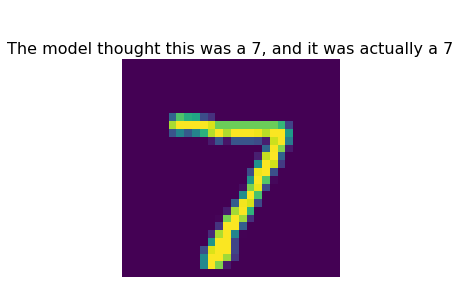

In [ ]:
def show(index, title):
    plt.figure()
    plt.imshow(X_test[index].reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

show(0, 'The model thought this was a {}, and it was actually a {}'.format(
    np.argmax(y_proba[0]), y_test[0]))


The REST API is nice and simple, and it works well when the input and output data are not too large. Moreover, just about any client application can make REST queries without additional dependencies, whereas other protocols are not always so readily available. However, it is based on JSON, which is text-based and fairly verbose. For example, we had to convert the NumPy array to a Python list, and every float ended up represented as a string. This is very inefficient, both in terms of serialization/deserialization time (to convert all the floats to strings and back) and in terms of payload size: many floats end up being represented using over 15 characters, which translates to over 120 bits for 32-bit floats! This will result in high latency and bandwidth usage when transferring large NumPy arrays.4 So let’s use gRPC instead.

**Note**: When transferring large amounts of data, it is much better to use the gRPC API (if the client supports it), as it is based on a compact binary format and an efficient communication protocol (based on HTTP/2 framing).

### Querying TF Serving through the gRPC API

The gRPC API expects a serialized `PredictRequest` protocol buffer as input, and it outputs a serialized `PredictResponse` protocol buffer. These protobufs are part of the `tensorflow-serving-api` library, which we must install (e.g., using pip). First, let’s create the request:

In [ ]:
!pip install -q -U tensorflow-serving-api

In [ ]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(X_test[:3]))

This code creates a `PredictRequest` protocol buffer and fills in the required fields, including the model name (defined earlier), the signature name of the function we want to call, and finally the input data, in the form of a `Tensor` protocol buffer. The `tf.make_tensor_proto()` function creates a Tensor protocol buffer based on the given tensor or NumPy array, in this case `X_new`.

Next, we’ll send the request to the server and get its response (for this we will need the `grpcio` library, which we can install using pip):

In [ ]:
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

In [ ]:
response

outputs {
  key: "Softmax"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 3
      }
      dim {
        size: 10
      }
    }
    float_val: 1.0176953765039798e-05
    float_val: 4.316563495532222e-10
    float_val: 4.436568633536808e-05
    float_val: 0.0017675909912213683
    float_val: 2.764317912351544e-07
    float_val: 2.7024723749491386e-05
    float_val: 3.617923183263372e-10
    float_val: 0.9978255033493042
    float_val: 3.565489805623656e-06
    float_val: 0.0003214747121091932
    float_val: 0.0011934504145756364
    float_val: 3.597992690629326e-05
    float_val: 0.9352307319641113
    float_val: 0.007069199811667204
    float_val: 1.8756937669728302e-10
    float_val: 0.039686378091573715
    float_val: 0.014937933534383774
    float_val: 1.4017121339506e-13
    float_val: 0.0018462629523128271
    float_val: 8.416913832576256e-10
    float_val: 1.43477182064089e-05
    float_val: 0.9812043309211731
    float_val: 0.009082535281777382
    flo

The code is quite straightforward: after the imports, we create a gRPC communication channel to *localhost* on TCP port 8500, then we create a gRPC service over this channel and use it to send a request, with a 10-second timeout (not that the call is synchronous: it will block until it receives the response or the timeout period expires). In this example the channel is insecure (no encryption, no authentication), but gRPC and TensorFlow Serving also support secure channels over SSL/TLS.

Next, let’s convert the PredictResponse protocol buffer to a tensor:

In [ ]:
output_name = model.output_names[0]
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)

If we run this code and print `y_proba.numpy().round(2)`, we will get the exact same estimated class probabilities as earlier.

In [ ]:
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.94, 0.01, 0.  , 0.04, 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.98, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

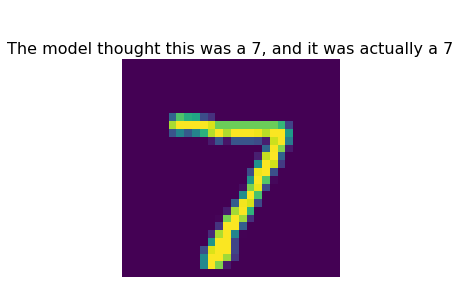

In [ ]:
show(0, 'The model thought this was a {}, and it was actually a {}'.format(
    np.argmax(y_proba[0]), y_test[0]))

 And that’s all there is to it: in just a few lines of code, we can now access our TensorFlow model remotely, using either REST or gRPC.

### Deploying a new model version

Now let’s create a new model version and export a SavedModel to the `my_mnist_model/0002` directory, just like earlier:

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

# train and evaluate our model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3727 - accuracy: 0.8949 - val_loss: 0.2065 - val_accuracy: 0.9412
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1784 - accuracy: 0.9485 - val_loss: 0.1466 - val_accuracy: 0.9568
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1348 - accuracy: 0.9614 - val_loss: 0.1225 - val_accuracy: 0.9644
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1128 - accuracy: 0.9666 - val_loss: 0.1048 - val_accuracy: 0.9680
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0987 - accuracy: 0.9704 - val_loss: 0.1038 - val_accuracy: 0.9700
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0901 - accuracy: 0.9725 - val_loss: 0.1011 - val_accuracy: 0.9714
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0826 - accuracy: 0.9748 - val_loss: 0.0984 - val_accuracy:

In [ ]:
model_version = "0002"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
print('Path where the model will be stored: {}\n'.format(model_path))
tf.saved_model.save(model, model_path)

Path where the model will be stored: my_mnist_model/0002

INFO:tensorflow:Assets written to: my_mnist_model/0002/assets


In [ ]:
for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

my_mnist_model/
    0002/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index
    0001/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


At regular intervals (the delay is configurable), TensorFlow Serving checks for new model versions. If it finds one, it will automatically handle the transition gracefully: by default, it will answer pending requests (if any) with the previous model version, while handling new requests with the new version. As soon as every pending request has been answered, the previous model version is unloaded. 

**Note**: We may need to wait a minute before the new model is loaded by TensorFlow Serving.

In [ ]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [ ]:
response.keys()

dict_keys(['predictions'])

In [ ]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

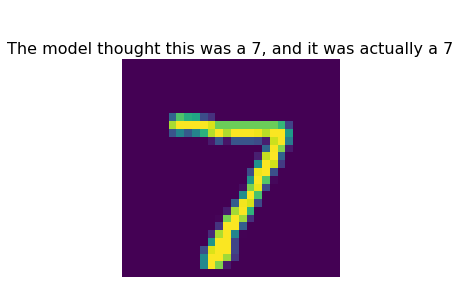

In [ ]:
show(0, 'The model thought this was a {}, and it was actually a {}'.format(
    np.argmax(y_proba[0]), y_test[0]))

This approach offers a smooth transition, but it may use too much RAM (especially GPU RAM, which is generally the most limited). In this case, we can configure TF Serving so that it handles all pending requests with the previous model version and unloads it before loading and using the new model version. This configuration will avoid having two model versions loaded at the same time, but the service will be unavailable for a short period.

As we can see, TF Serving makes it quite simple to deploy new models. Moreover, if we discover that version 2 does not work as well as we expected, then rolling back to version 1 is as simple as removing the `my_mnist_model/0002` directory.

**Note**: Another great feature of TF Serving is its automatic batching capability, which we can activate using the `--enable_batching` option upon startup. When TF Serving receives multiple requests within a short period of time (the delay is configurable), it will automatically batch them together before using the model. This offers a significant performance boost by leveraging the power of the GPU. Once the model returns the predictions, TF Serving dispatches each prediction to the right client. We can trade a bit of latency for a greater throughput by increasing the batching delay (see the `--batching_parameters_file` option).

# References

- [Train and serve a TensorFlow model with TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [Github: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://github.com/ageron/handson-ml2)

- [Ease ML deployments with TensorFlow Serving](https://youtu.be/4mqFDwIdKh0)

- [Building Machine Learning Pipelines](https://learning.oreilly.com/library/view/building-machine-learning/9781492053187/)

file:///home/lenovo/Documents/docs/deep%20learning/hands_on_ML_htmls/models_at_scale.html

https://github.com/ageron/handson-ml2/blob/master/19_training_and_deploying_at_scale.ipynb
